## Data Analysis

### 1. Read the data file and clean data

In [1]:
# import library
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from pandas import option_context
from statsmodels.iolib.summary2 import summary_col

import nltk
nltk.download('vader_lexicon')

import warnings
warnings.simplefilter('ignore')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
obj=SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brinxu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# read data
df = pd.read_csv('covid_data_final_with_scores.csv', low_memory=False)

In [3]:
# generate radom number to post id.
def generate_id(s):
    return abs(hash(s)) % (10 ** 10)

df.insert(0, "Post Id", df['Post Created'].apply(generate_id), True)

In [4]:
word_count = []
# count number of word in each row of the column of "Message"
split_string = df['Message'].str.split()
for string in split_string:
    words = len(string)
    word_count.append(words)     

In [5]:
# create a new column and gives it the value of the right side. 
df['word_count'] = word_count

In [6]:
# change date format
df['Post Created Date'] = pd.to_datetime(df['Post Created Date'])
df['Page Created'] = pd.to_datetime(df['Page Created'])

df['Post_Created_Month'] = df['Post Created Date'].dt.month
df['Page_Created_Month'] = df['Page Created'].dt.month

In [7]:
# extract data for 1st Jan 2020 to 30th June 2021
extract = (df['Post Created Date'] > '01-01-2020') & (df['Post Created Date'] <= '30-06-2021')

df = df.loc[extract]
df.head()

,Post Id,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,...,authority_sent,sanctity_sent,moral_nonmoral_ratio,f_var,sent_var,clean_post,Liberty/oppression,word_count,Post_Created_Month,Page_Created_Month
0,9306643036,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34563652,38358192.0,...,-0.070749,-0.175241,0.777778,0.000574,0.004499,pair we senator ask biden administration inter...,0.479592,27,6,11
1,2135528023,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34563652,38358192.0,...,0.086809,0.046238,1.000000,0.000429,0.001634,little evidence delta variant bypass protectio...,0.575510,27,6,11
2,1112618982,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34563652,38358192.0,...,-0.065666,-0.057119,0.777778,0.000388,0.000599,stark disparity low high vaccination area some...,0.448980,32,6,11
3,1410103951,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34563652,38358192.0,...,0.061423,0.024422,1.166667,0.000080,0.004956,we surgeon general dr vivek murthy say concern...,0.489796,58,6,11
4,1604350301,CNN,cnn,5550296508,MEDIA_NEWS_COMPANY,US,Instant breaking news alerts and the most talk...,2007-11-07 22:14:27,34563652,38358192.0,...,-0.157422,-0.168818,1.000000,0.000757,0.002340,kim jong un fire several senior official fail ...,0.357143,16,6,11


In [8]:
# rename the column
df['liberty_p'] = df['Liberty/oppression']

In [9]:
# change missing to 0
df['liberty_p'] = df['liberty_p'].fillna(0)

In [10]:
# generate sentiment and map it
df['PN']=df['Message'].apply(lambda x:[key for key, value in obj.polarity_scores(x).items() if (value == max(obj.polarity_scores(x)['pos'],obj.polarity_scores(x)['neg']) and key in ["pos","neg"])][0])

In [11]:
df['PN']

0        pos
1        pos
2        neg
3        pos
4        neg
        ... 
82384    pos
82385    pos
82386    pos
82387    neg
82388    neg
Name: PN, Length: 80919, dtype: object

In [12]:
df['PN'].unique()

array(['pos', 'neg'], dtype=object)

In [13]:
df['PN'].value_counts()

neg    47550
pos    33369
Name: PN, dtype: int64

In [14]:
mappings = {"pos": 1, "neg": 0}
df["PN"] = df["PN"].map(mappings)

In [15]:
# remove duplicated messages
df = df.drop_duplicates(subset='Message', keep="first")

In [16]:
df.LNC_category.unique()

array(['liberal', nan, 'conservative'], dtype=object)

In [17]:
df.dropna(subset="LNC_category", axis=0, inplace=True)

In [18]:
mappings = {"liberal": 1, "conservative": 0}
df["LNC_category"] = df["LNC_category"].map(mappings)

In [19]:
df['Followers_at_Posting']=df['Followers at Posting']/1000
df['Followers_at_Posting']

0        38358.192
1        38358.192
2        38358.192
3        38358.192
4        38358.192
           ...    
82333     3249.592
82334     3183.099
82335     3182.963
82336     3182.963
82337     3178.370
Name: Followers_at_Posting, Length: 43560, dtype: float64

In [20]:
df['log_Likes'] = np.log(df['Likes']+1)
df['log_comments'] = np.log(df['Comments']+1)
df['log_Shares'] = np.log(df['Shares']+1)

In [21]:
df['log_Likes']=df['log_Likes'].dropna()
df['log_comments']=df['log_comments'].dropna()
df['log_Shares']=df['log_Shares'].dropna()

In [22]:
df['LNC_category']=df['LNC_category'].dropna()

In [23]:
df['LNC_category'].unique()

array([1, 0])

In [25]:
df['LNC_category'].value_counts()

1    35703
0     7857
Name: LNC_category, dtype: int64

In [26]:
# remove http/https
import re
def remove_https_links(message):
    return re.sub(r'http\S+', '', message, flags=re.MULTILINE)

In [27]:
# Apply the function named remove_... on the column
df["Message"] = df["Message"].apply(remove_https_links)

In [28]:
df.skew()

Post Id                            -0.002539
Facebook Id                         3.471359
Likes at Posting                    0.744961
Followers at Posting                0.790614
Likes                              11.990336
Comments                           12.224080
Shares                             22.701683
Love                               18.074876
Wow                                16.354572
Haha                               29.457308
Sad                                25.653120
Angry                              11.832166
Care                               32.168649
Post Views                        118.237373
Total Views                        91.631121
Total Views For All Crossposts    151.258268
LNC_category                       -1.662635
care_p                              0.578309
fairness_p                          0.551781
loyalty_p                           0.427095
authority_p                         0.809626
sanctity_p                          0.762676
care_sent 

In [71]:
df2 = df[['Page Name','Post Id','Facebook Id', 'Post Created Date','care_p', 'fairness_p', 'loyalty_p',
          'authority_p', 'sanctity_p', 'Likes', 'Comments', 'Shares', 'PN', 'LNC_category', 'Page Created',
          'Type', 'Message', 'word_count','Followers_at_Posting', 'Post_Created_Month', 'Page_Created_Month',
          'liberty_p', 'log_Likes', 'log_comments', 'log_Shares']]

### 2. Check the distribution of data

In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43560 entries, 0 to 82337
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Page Name             43560 non-null  object        
 1   Post Id               43560 non-null  int64         
 2   Facebook Id           43560 non-null  int64         
 3   Post Created Date     43560 non-null  datetime64[ns]
 4   care_p                43560 non-null  float64       
 5   fairness_p            43560 non-null  float64       
 6   loyalty_p             43560 non-null  float64       
 7   authority_p           43560 non-null  float64       
 8   sanctity_p            43560 non-null  float64       
 9   Likes                 43560 non-null  int64         
 10  Comments              43560 non-null  int64         
 11  Shares                43560 non-null  int64         
 12  PN                    43560 non-null  int64         
 13  LNC_category    

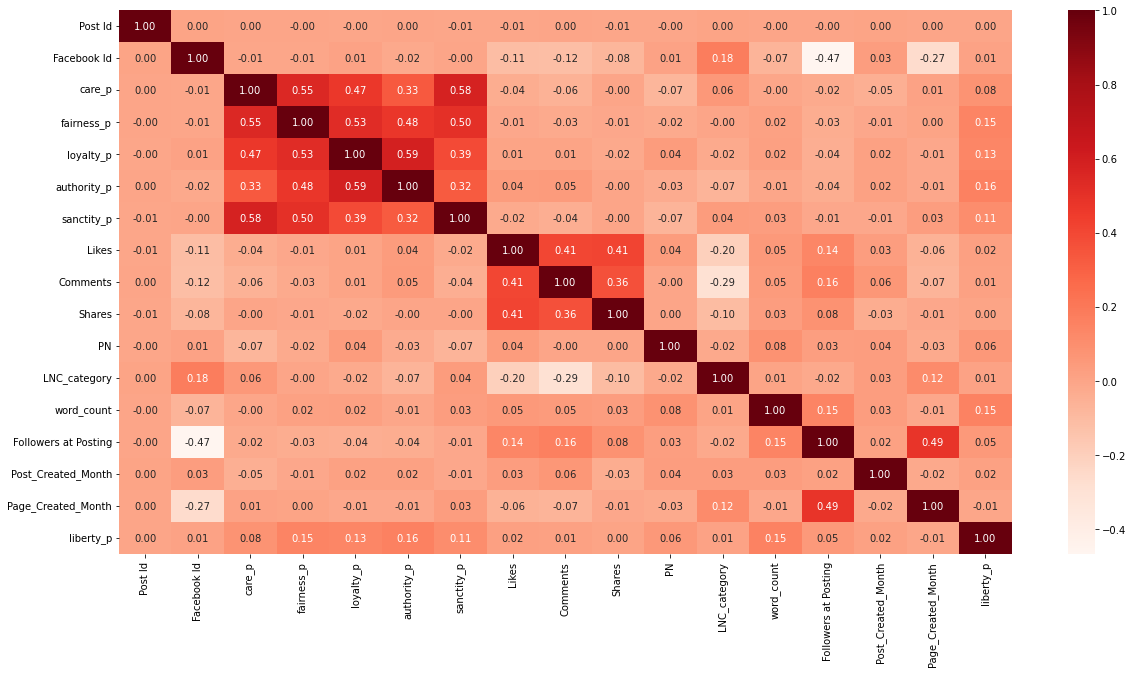

In [31]:
corr = df2.corr()
#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()

In [32]:
df2.groupby('Page Name')['care_p', 'fairness_p', 'loyalty_p', 'authority_p', 'sanctity_p', 'liberty_p'].mean()

,care_p,fairness_p,loyalty_p,authority_p,sanctity_p,liberty_p
Page Name,,,,,,
BBC,0.109915,0.100000,0.090812,0.089740,0.085731,0.470114
Breitbart,0.108332,0.103468,0.094435,0.098487,0.082998,0.465986
CNN,0.107239,0.099005,0.089578,0.090896,0.081108,0.504136
Daily Kos,0.115553,0.107276,0.096415,0.096759,0.086024,0.460706
Fox News,0.101057,0.097521,0.090172,0.095510,0.076352,0.497799
MSNBC,0.106318,0.099314,0.090975,0.092613,0.079887,0.496060
NBC,0.090965,0.082680,0.086798,0.087898,0.081438,0.530215
NPR,0.109564,0.100567,0.090576,0.092946,0.081320,0.484205
The New York Times,0.108388,0.100022,0.089713,0.092964,0.082233,0.487550


In [33]:
df2.groupby('Page Name')['care_p'].mean().sort_values()

Page Name
NBC                   0.090965
Fox News              0.101057
MSNBC                 0.106318
TheBlaze              0.106838
CNN                   0.107239
Washington Post       0.107529
Breitbart             0.108332
The New York Times    0.108388
NPR                   0.109564
BBC                   0.109915
Daily Kos             0.115553
Name: care_p, dtype: float64

In [54]:
# Conservative sample
df_con = df2[df2['LNC_category'] == 0]

In [55]:
# Liberal sample
df_lib = df2[df2['LNC_category'] == 1]

### 3. Mapping care_p & message

First, apply mapping to the full sample

In [36]:
dict_of_quantile = dict(df2.quantile(0.9))

In [37]:
dict_of_quantile

{'Post Id': 8979984336.3,
 'Facebook Id': 273864989376427.0,
 'care_p': 0.1424073638815102,
 'fairness_p': 0.12889168939177545,
 'loyalty_p': 0.11474909956988572,
 'authority_p': 0.11995425056259564,
 'sanctity_p': 0.10628977911576865,
 'Likes': 5348.199999999997,
 'Comments': 2528.199999999997,
 'Shares': 1775.0,
 'PN': 1.0,
 'LNC_category': 1.0,
 'word_count': 46.0,
 'Followers at Posting': 35871975.79999998,
 'Post_Created_Month': 11.0,
 'Page_Created_Month': 11.0,
 'liberty_p': 0.6258503401360546}

In [44]:
# top 10% of care_p
top10 = df2[df2["care_p"] > dict_of_quantile['care_p'] ]

In [45]:
dict_of_10 = dict(top10.quantile(0.9))

In [46]:
# generate bottom 10% from the highest care_p score
dict_of_quantile_b = dict(top10.quantile(0.1))

In [47]:
top10_bot10 = df2[df2["log_Likes"] < dict_of_quantile_b["log_Likes"]]

In [48]:
top10_bot10["Message"].head(100).to_csv("top10_bot10.csv", index=False)

Second, apply mapping to the conservative subsample

In [57]:
dict_of_quantile_con = dict(df_con.quantile(0.9))

In [58]:
top10_con = df_con[df_con["care_p"] > dict_of_quantile_con['care_p'] ]

In [59]:
dict_of_10_con = dict(top10_con.quantile(0.9))

In [60]:
dict_of_quantile_con_b = dict(top10_con.quantile(0.1))

In [61]:
top10_bot10_con = df_con[df_con["log_Likes"] < dict_of_quantile_con_b["log_Likes"]]

In [62]:
top10_bot10_con["Message"].head(100).to_csv("top10_bot10_con.csv", index=False)

Second, apply mapping to the liberal subsample

In [63]:
dict_of_quantile_lib = dict(df_lib.quantile(0.9))

In [64]:
top10_lib = df_lib[df_lib["care_p"] > dict_of_quantile_lib['care_p'] ]

In [65]:
dict_of_10_lib = dict(top10_lib.quantile(0.9))

In [66]:
dict_of_quantile_lib_b = dict(top10_lib.quantile(0.1))

In [67]:
top10_bot10_lib = df_lib[df_lib["log_Likes"] < dict_of_quantile_lib_b["log_Likes"]]

In [68]:
top10_bot10_lib["Message"].head(100).to_csv("top10_bot10_lib.csv", index=False)

## Run regression

In [72]:
# For full sample 
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df2.dropna(), test_size = .2) 

full_sample = smf.mixedlm("log_Likes ~ care_p + fairness_p + loyalty_p + authority_p + sanctity_p + liberty_p+\
Post_Created_Month+ Page_Created_Month + word_count + C(PN) + Followers_at_Posting + C(LNC_category)", 
data = df2.dropna(), groups= "Facebook Id").fit()
print("Model: ", 1)
print(full_sample.summary())

Model:  1
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   log_Likes  
No. Observations:   43560     Method:               REML       
No. Groups:         11        Scale:                1.6451     
Min. group size:    15        Log-Likelihood:       -72713.0699
Max. group size:    9232      Converged:            Yes        
Mean group size:    3960.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             5.410    0.739  7.316 0.000  3.961  6.859
C(PN)[T.1]            0.130    0.013 10.209 0.000  0.105  0.155
C(LNC_category)[T.1] -0.584    0.580 -1.007 0.314 -1.720  0.553
care_p               -2.592    0.290 -8.933 0.000 -3.161 -2.023
fairness_p           -0.228    0.355 -0.643 0.520 -0.924  0.467
loyalty_p             0.467    0.422  1.109

In [73]:
# For full sample (by ideology)
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df2.dropna(), test_size = .2) 

full_sample = smf.mixedlm("log_Likes ~ care_p + fairness_p + loyalty_p + authority_p + sanctity_p + liberty_p +\
care_p:LNC_category + fairness_p:LNC_category + loyalty_p:LNC_category + authority_p:LNC_category +\
sanctity_p:LNC_category + liberty_p:LNC_category + Post_Created_Month+ Page_Created_Month + word_count\
+ C(PN) + Followers_at_Posting + C(LNC_category)", 
data = df2.dropna(), groups= "Facebook Id").fit()
print("Model: ", 1)
print(full_sample.summary())

Model:  1
               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    log_Likes  
No. Observations:     43560      Method:                REML       
No. Groups:           11         Scale:                 1.6448     
Min. group size:      15         Log-Likelihood:        -72703.0261
Max. group size:      9232       Converged:             Yes        
Mean group size:      3960.0                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 5.441    0.742  7.330 0.000  3.986  6.896
C(PN)[T.1]                0.130    0.013 10.205 0.000  0.105  0.155
C(LNC_category)[T.1]     -0.625    0.586 -1.066 0.286 -1.774  0.524
care_p                   -3.573    0.669 -5.341 0.000 -4.885 -2.262
fairness_p               -0.881    0.804 -1.096 0.273

### 4. Run topic models

First, tokenize and cleanup text (lowercase, remove stopwords), lemmatize

Reference: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [75]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brinxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
stop_words = stopwords.words('english')
stop_words.extend(['vaccine', 'from', 'subject', 're', 'edu', 'use', 'Covid19', 'COVID-19', 'Covid', 'Corona', 'Coronavirus', '2019ncov', 'Ncov', 'Pandemic', 'Social distancing', 'Lockdown', 'Quarantine', 'SARS-CoV-2', 'N95'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43560 entries, 0 to 82337
Data columns (total 60 columns):
 #   Column                                                                                                              Non-Null Count  Dtype         
---  ------                                                                                                              --------------  -----         
 0   Post Id                                                                                                             43560 non-null  int64         
 1   Page Name                                                                                                           43560 non-null  object        
 2   User Name                                                                                                           43560 non-null  object        
 3   Facebook Id                                                                                                         43560 non-

In [79]:
# Stemming and lemmatization
from nltk.stem.porter import PorterStemmer

def stem_it(x):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in x]

df['Message'] = df['Message'].apply(stem_it) 
df.tail()

,Post Id,Page Name,User Name,Facebook Id,Page Category,Page Admin Top Country,Page Description,Page Created,Likes at Posting,Followers at Posting,...,Liberty/oppression,word_count,Post_Created_Month,Page_Created_Month,liberty_p,PN,Followers_at_Posting,log_Likes,log_comments,log_Shares
82333,9182372519,NBC,nbc,89742860745,TV_NETWORK,US,America’s Most Watched Network. The official F...,2009-04-21 21:27:43,3031931,3249592.0,...,0.591837,21,6,4,0.591837,1,3249.592,5.075174,3.433987,4.077537
82334,6905011240,NBC,nbc,89742860745,TV_NETWORK,US,America’s Most Watched Network. The official F...,2009-04-21 21:27:43,3028006,3183099.0,...,0.438776,22,5,4,0.438776,0,3183.099,5.123964,2.708050,3.218876
82335,2511083578,NBC,nbc,89742860745,TV_NETWORK,US,America’s Most Watched Network. The official F...,2009-04-21 21:27:43,3027936,3182963.0,...,0.418367,36,5,4,0.418367,1,3182.963,4.897840,3.433987,2.708050
82336,5556756817,NBC,nbc,89742860745,TV_NETWORK,US,America’s Most Watched Network. The official F...,2009-04-21 21:27:43,3027936,3182963.0,...,0.532908,44,5,4,0.532908,1,3182.963,4.543295,2.079442,1.945910
82337,1492268168,NBC,nbc,89742860745,TV_NETWORK,US,America’s Most Watched Network. The official F...,2009-04-21 21:27:43,3025596,3178370.0,...,0.482993,46,4,4,0.482993,1,3178.370,4.820282,2.639057,3.258097


In [80]:
# normalize the stopwords list to lower case
stop_words = list(map(lambda x: x.lower(), stop_words))

In [81]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [82]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [83]:
# need to fix here
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [84]:
top10_bot10["clean_message"] = top10_bot10["Message"].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words])
)

In [85]:
# top10.clean_message

In [86]:
data = top10_bot10.clean_message.values.tolist()
data_words = list(sent_to_words(data))

In [87]:
data_lib = df_lib.Message.values.tolist()
data_words_lib = list(sent_to_words(data_lib))

In [88]:
data_con = df_con.Message.values.tolist()
data_words_con = list(sent_to_words(data_con))

In [89]:
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['texans', 'enough', 'worry', 'icy', 'storm', 'led', 'power', 'outages', 'water', 'problem', 'like', 'tania', 'delacruz', 'added', 'woe', 'cnn', 'miguel', 'marquez']


In [90]:
data_words_lib = remove_stopwords(data_words_lib)
data_words_con = remove_stopwords(data_words_con)

In [91]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1][0][:30])

In [92]:
texts_lib = data_words_lib
texts_con = data_words_con

In [93]:
corpus_lib= [id2word.doc2bow(text_lib) for text_lib in texts_lib]
corpus_con = [id2word.doc2bow(text_con) for text_con in texts_con]

In [94]:
from gensim.models import CoherenceModel
import operator

In [95]:
## Finding the right number of topics
list_of_n_topics = list(range(3,15))

list_of_coherence = {}

for i in list_of_n_topics:
    print(f"Processing the {i} topic")
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i,
                                           random_state = 100,
                                          chunksize = 100,
                                          alpha='auto',
                                          per_word_topics = True)
    # calculate the coherency metric
    cm = CoherenceModel(model= lda_model, corpus=corpus, coherence='u_mass')
    
    # save the coherency value to my dictionary
    list_of_coherence[str(i)] = cm.get_coherence()

Processing the 3 topic
Processing the 4 topic
Processing the 5 topic
Processing the 6 topic
Processing the 7 topic
Processing the 8 topic
Processing the 9 topic
Processing the 10 topic
Processing the 11 topic
Processing the 12 topic
Processing the 13 topic
Processing the 14 topic


In [96]:
sorted_coherence_LDA = sorted(list_of_coherence.items(), key=operator.itemgetter(1))

In [97]:
sorted_coherence_LDA

[('13', -12.50973152262455),
 ('14', -12.403862635418792),
 ('12', -12.255422054160588),
 ('11', -12.020685288424177),
 ('10', -11.613952941183058),
 ('9', -10.95762803235685),
 ('8', -10.763663448728956),
 ('7', -9.530222022239125),
 ('6', -7.890333613537281),
 ('5', -7.792973802189214),
 ('3', -6.0378162834163644),
 ('4', -5.904702592477744)]

the more reasonbale value for the number of topics is 4, and by applying it from a new cell we we can check the new results again

In [98]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [99]:
# Print the Keyword in the 10 topics in full sample
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"new" + 0.009*"state" + 0.009*"says" + 0.007*"election" + '
  '0.007*"cases" + 0.007*"results" + 0.006*"americans" + 0.006*"could" + '
  '0.006*"get" + 0.006*"amid"'),
 (1,
  '0.010*"us" + 0.009*"says" + 0.008*"people" + 0.008*"cases" + 0.008*"dr" + '
  '0.007*"trump" + 0.006*"new" + 0.005*"deaths" + 0.005*"president" + '
  '0.005*"one"'),
 (2,
  '0.006*"us" + 0.006*"says" + 0.005*"people" + 0.005*"new" + '
  '0.004*"americans" + 0.004*"one" + 0.004*"trump" + 0.004*"cases" + '
  '0.003*"year" + 0.003*"country"'),
 (3,
  '0.007*"says" + 0.006*"people" + 0.006*"trump" + 0.005*"new" + '
  '0.004*"president" + 0.004*"dr" + 0.004*"time" + 0.004*"health" + 0.004*"us" '
  '+ 0.003*"amid"')]


In [100]:
# Print the Keyword in the topics in conservative media
lda_model_con = gensim.models.LdaMulticore(corpus=corpus_con,
                                           id2word=id2word,
                                           num_topics=num_topics)

pprint(lda_model_con.print_topics())
doc_lda = lda_model_con[corpus_con]

[(0,
  '0.010*"new" + 0.009*"news" + 0.008*"said" + 0.008*"first" + 0.007*"trump" + '
  '0.006*"president" + 0.006*"fox" + 0.005*"state" + 0.005*"tuesday" + '
  '0.004*"house"'),
 (1,
  '0.020*"president" + 0.015*"trump" + 0.009*"new" + 0.009*"said" + '
  '0.008*"chinese" + 0.007*"donald" + 0.007*"biden" + 0.006*"gov" + '
  '0.006*"health" + 0.006*"home"'),
 (2,
  '0.012*"president" + 0.010*"trump" + 0.009*"state" + 0.006*"new" + '
  '0.006*"americans" + 0.006*"said" + 0.006*"donald" + 0.006*"amid" + '
  '0.006*"news" + 0.005*"people"'),
 (3,
  '0.011*"new" + 0.009*"trump" + 0.009*"president" + 0.009*"house" + '
  '0.008*"said" + 0.008*"fox" + 0.006*"news" + 0.006*"donald" + 0.006*"china" '
  '+ 0.006*"people"')]


In [101]:
# Print the Keyword in the top topics in liberal media
lda_model_lib = gensim.models.LdaMulticore(corpus=corpus_lib,
                                           id2word=id2word,
                                           num_topics=num_topics)

pprint(lda_model_lib.print_topics())
doc_lda = lda_model_lib[corpus_lib]

[(0,
  '0.014*"people" + 0.010*"new" + 0.007*"one" + 0.006*"health" + '
  '0.005*"million" + 0.005*"trump" + 0.005*"states" + 0.005*"cases" + '
  '0.005*"said" + 0.005*"country"'),
 (1,
  '0.010*"president" + 0.010*"new" + 0.009*"trump" + 0.009*"people" + '
  '0.007*"health" + 0.006*"one" + 0.006*"says" + 0.005*"dr" + 0.005*"said" + '
  '0.005*"cases"'),
 (2,
  '0.015*"new" + 0.010*"president" + 0.009*"says" + 0.008*"trump" + '
  '0.007*"cases" + 0.007*"said" + 0.006*"people" + 0.006*"health" + '
  '0.005*"house" + 0.005*"first"'),
 (3,
  '0.011*"new" + 0.010*"says" + 0.009*"us" + 0.006*"state" + 0.006*"cases" + '
  '0.006*"people" + 0.005*"trump" + 0.005*"president" + 0.005*"first" + '
  '0.004*"health"')]
